In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from random import random
from monte_carlo import Monte_carlo_dla
from growth_model import growth_model

# A)

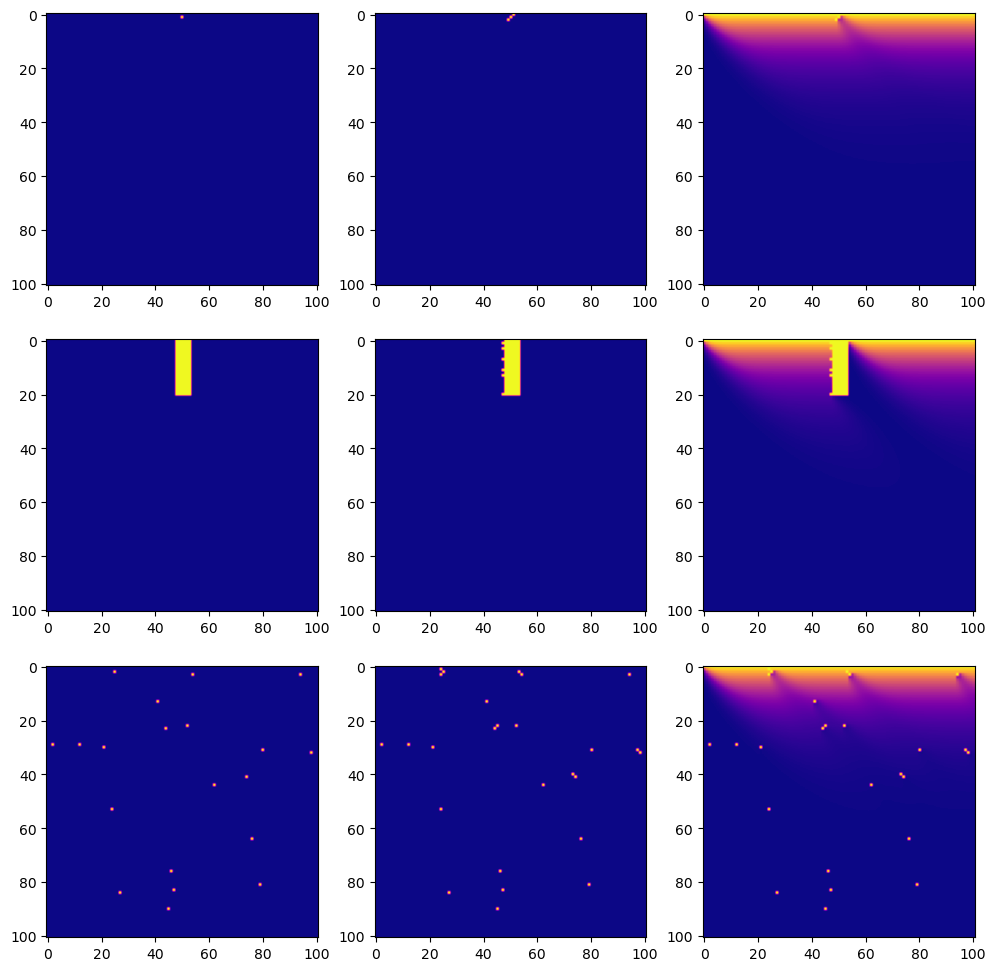

In [34]:
N = 100
w = 1.9
eta = 0.6
stop = 0.00001

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

[C, cluster, n_count] = growth_model(N, [[1], [50]], w, eta, stop)
axs[0,0].imshow(cluster[0],cmap='plasma')
axs[0,1].imshow(cluster[n_count],cmap='plasma')
axs[0,2].imshow(C[n_count],cmap='plasma')

position_0 = []
position_1 = []
for i in range(21):
    for j in range(6):
        position_0.append(i)
        position_1.append(48+j)
[C, cluster, n_count] = growth_model(N, [position_0, position_1], w, eta, stop)
axs[1,0].imshow(cluster[0],cmap='plasma')
axs[1,1].imshow(cluster[n_count],cmap='plasma')
axs[1,2].imshow(C[n_count],cmap='plasma')

position_0 = np.random.randint(100, size = 20)
position_1 = np.random.randint(100, size = 20)
[C, cluster, n_count] = growth_model(N, [position_0, position_1], w, eta, stop)
axs[2,0].imshow(cluster[0],cmap='plasma')
axs[2,1].imshow(cluster[n_count],cmap='plasma')
axs[2,2].imshow(C[n_count],cmap='plasma')

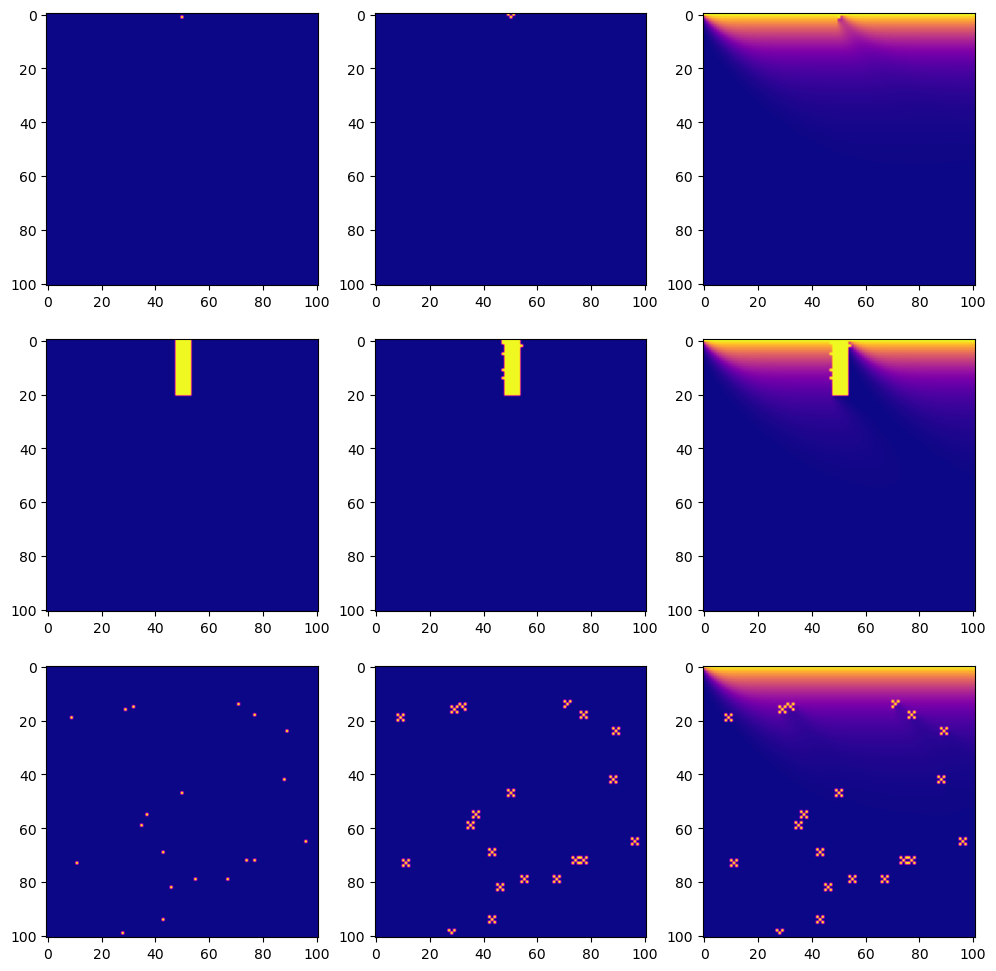

In [35]:
N = 100
w = 1.9
eta = 1.6
stop = 0.00001

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

[C, cluster, n_count] = growth_model(N, [[1], [50]], w, eta, stop)
axs[0,0].imshow(cluster[0],cmap='plasma')
axs[0,1].imshow(cluster[n_count],cmap='plasma')
axs[0,2].imshow(C[n_count],cmap='plasma')

position_0 = []
position_1 = []
for i in range(21):
    for j in range(6):
        position_0.append(i)
        position_1.append(48+j)
[C, cluster, n_count] = growth_model(N, [position_0, position_1], w, eta, stop)
axs[1,0].imshow(cluster[0],cmap='plasma')
axs[1,1].imshow(cluster[n_count],cmap='plasma')
axs[1,2].imshow(C[n_count],cmap='plasma')

position_0 = np.random.randint(100, size = 20)
position_1 = np.random.randint(100, size = 20)
[C, cluster, n_count] = growth_model(N, [position_0, position_1], w, eta, stop)
axs[2,0].imshow(cluster[0],cmap='plasma')
axs[2,1].imshow(cluster[n_count],cmap='plasma')
axs[2,2].imshow(C[n_count],cmap='plasma')


## B)

In [2]:
N = 100
n_particles = 20_000
p_list = np.linspace(0,1,num = 4)

In [5]:
monte_carlos = black_scholes = np.vectorize(Monte_carlo_dla, excluded=['N', 'n_particles'])(N,n_particles,p_list)

In [6]:
values = []
for i in monte_carlos:
    values += [i.A]
values = np.array(values)

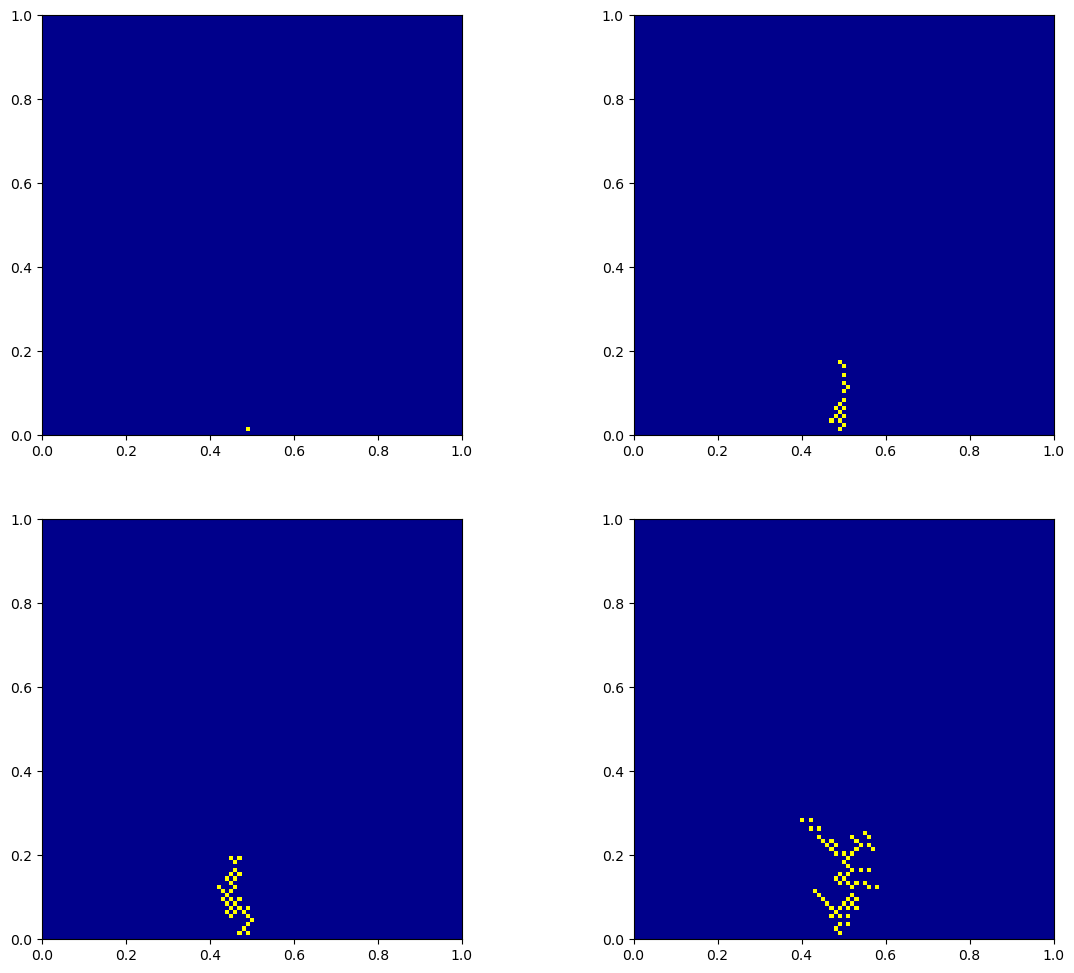

In [14]:
fig,axs = plt.subplots(2,2, figsize = (14,12))
axs = axs.flatten()

for i,ax in enumerate(axs):
    ax.imshow(values[i][1:-1, 1:-1], cmap= plt.cm.colors.ListedColormap(['darkblue', 'white', 'yellow']), interpolation='nearest', extent=[0, 1, 0, 1])